First read in data and create grid of inputs which is superset of predictor vectors in training data. Also select 15 random points from each of 4 classes. The data was generated following an unknown distribution with an unknown variance.

In [1]:
import pandas as pd

train=pd.read_csv('C:\local\data_sets\statistical_learning_data\HW2P3_train.csv')
test =pd.read_csv('C:\local\data_sets\statistical_learning_data\HW2P3_test.csv')
data = train.append(test)
print(data.shape)

import itertools, numpy as np
x1seq=list(np.linspace(min(train['X1'].tolist())-2,max(train['X1'].tolist())+2,100))
x2seq=list(np.linspace(min(train['X2'].tolist())-2,max(train['X2'].tolist())+2,100))
grid=pd.DataFrame(list(itertools.product(x1seq,x2seq)))
grid.columns=['X1','X2']

import random

classes=[]
scatter_points=[]
for c in range(4):
    classes.append(data[data['Y']==c])
    random.seed(c)
    samp_rows=random.sample(range(len(classes[c])), 15)
    scatter_points.append(classes[c].iloc[samp_rows,:])

(1550, 3)


In [2]:
for i in range(4):
    print('Class {} size: {}'.format(i, classes[i].shape[0]))

Class 0 size: 266
Class 1 size: 501
Class 2 size: 495
Class 3 size: 288


First fit linear discriminant analysis (LDA) and quadratic discriminant analysis (QDA) models on training data (n = 1550*.75).

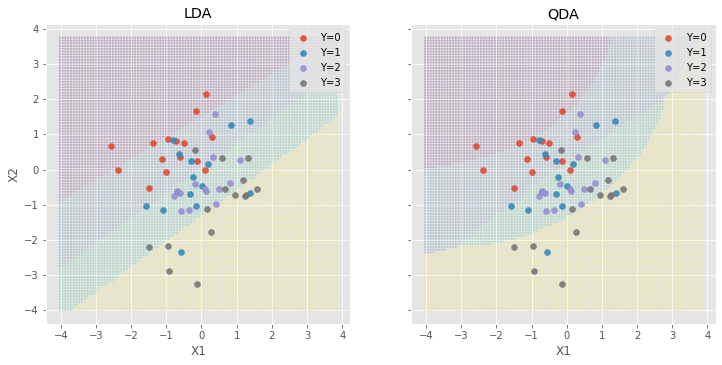

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Y'], axis=1), data['Y'], random_state=0)

lda_model=LinearDiscriminantAnalysis().fit(X_train, y_train)
grid_lda_predict=list(lda_model.predict(grid))

qda_model=QuadraticDiscriminantAnalysis().fit(X_train, y_train)
grid_qda_predict=list(qda_model.predict(grid))

import matplotlib
import matplotlib.pyplot as pyplot

pyplot.style.use('ggplot')
fig, axs = pyplot.subplots(1,2, sharey=True, figsize=(12,10))

titles=['LDA', 'QDA']
pred_grids = (list(lda_model.predict(grid)), list(qda_model.predict(grid)))

for ax in [0,1]:
    axs[ax].scatter(grid['X1'].tolist(),grid['X2'].tolist(),c=pred_grids[ax]
                    #,cmap=matplotlib.colors.ListedColormap(['green','cyan'])
                    ,alpha=.2,s=3)
    for i, s in enumerate(scatter_points):
        axs[ax].scatter(s['X1'].tolist(), s['X2'].tolist(), label='Y={}'.format(i), alpha=.9)
    #axs[ax].scatter(positives['X1'].tolist(),positives['X2'].tolist(),c='white',label='Y=1',alpha=.9)
    #axs[ax].scatter(negatives['X1'].tolist(),negatives['X2'].tolist(),c='black',label='Y=0',alpha=.9)
    
    axs[ax].legend()
    axs[ax].set_ylabel('X2')
    axs[ax].set_xlabel('X1')
    axs[ax].set_title(titles[ax])
    axs[ax].set_aspect(1)
    
    if ax==1:
        axs[ax].label_outer()

pyplot.show()

The training and testing One-vs-Rest AUCs (weighted to account for differences in number of occurences of each class) are:

In [4]:
from sklearn.metrics import roc_auc_score
print('LDA Training OVR_AUC: {}'
      .format(
              roc_auc_score(y_train, lda_model.predict_proba(X_train), multi_class='ovr', average='weighted')
      ))

print('LDA Testing OVR_AUC: {}'
     .format(
             roc_auc_score(y_test, lda_model.predict_proba(X_test), multi_class='ovr', average='weighted')
     ))

print('QDA Training OVR_AUC: {}'
      .format(
              roc_auc_score(y_train, qda_model.predict_proba(X_train), multi_class='ovr', average='weighted')
      ))

print('QDA Testing OVR_AUC: {}'
     .format(
             roc_auc_score(y_test, qda_model.predict_proba(X_test), multi_class='ovr', average='weighted')
     ))

LDA Training OVR_AUC: 0.7481643432119336
LDA Testing OVR_AUC: 0.7578165615382071
QDA Training OVR_AUC: 0.7487826724989742
QDA Testing OVR_AUC: 0.7605592978066145


Fitting support vector classifiers (SVCs) with radial kernels. The cost parameter C specifies the sum of square distances of points from the decision boundary where the point is outside of the decision region for its response classification (this distance is 0 if the point's classification coincides with its classification predicted by the SVC). As a result, C is generally proportional to the number of points which 'fall' on the wrong side of the classifier with respect to their associated response value. Also, C generally results in more complex boundary regions.

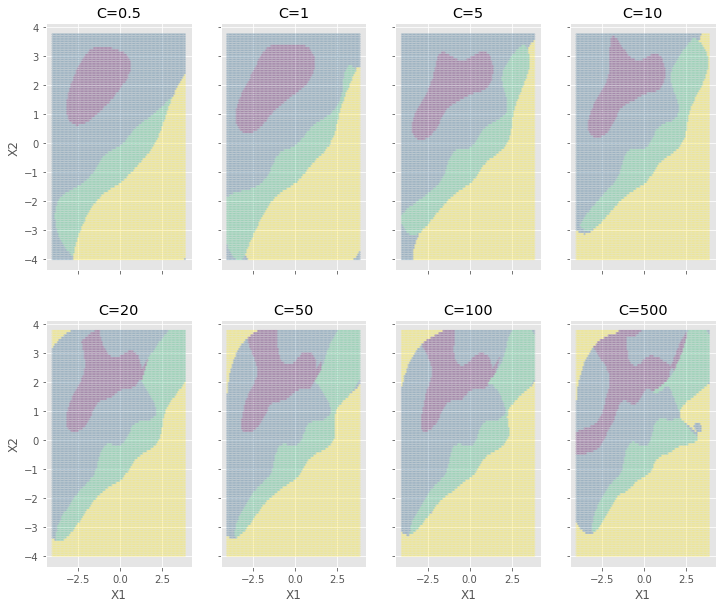

In [5]:
from sklearn.svm import SVC

c_seq=[.5,1,5,10,20,50,100,500]

pyplot.style.use('ggplot')
fig, axs = pyplot.subplots(2,4, figsize=(12,10))

def plot_boundaries(param_name, param_list, fig, ax):
    train_aucs, test_aucs = [], []
    
    for i, p in enumerate(param_list):
        
        if param_name=='C':
            svc=SVC(C=p, probability=True).fit(X_train, y_train)
        elif param_name=='gamma':
            svc=SVC(gamma=p, probability=True).fit(X_train, y_train)
            
        row, col = int(i>=4), (i%4)

        grid_predictions=svc.predict(grid).tolist()
        axs[row,col].scatter(grid['X1'].tolist(),grid['X2'].tolist()
                             ,c=grid_predictions
                             ,alpha=.2,s=3)

        axs[row,col].set_ylabel('X2')
        axs[row,col].set_xlabel('X1')
        axs[row,col].set_title('{}={}'.format(param_name, p))
        axs[row,col].label_outer()
        
        train_aucs.append(roc_auc_score(y_train, svc.predict_proba(X_train), multi_class='ovr', average='weighted'))
        test_aucs.append(roc_auc_score(y_test, svc.predict_proba(X_test), multi_class='ovr', average='weighted'))
    
    return train_aucs, test_aucs

svc_c_train, svc_c_test = plot_boundaries('C', c_seq, fig, axs)
pyplot.show()

As C increases, the SVC is increasingly more likely to be overfit to the data. Accordingly, notice the training AUCs are generally increasing, but the testing AUCs are generally decreasing. Increasing of the training AUCs was expected when increasing C, since larger C allows for a more complex decision boundary which is closer to an interpolation of the training set. However, overly complex decision boundaries are more likely to poorly estimate the true relationship between the covariates and response, resulting in decreasing testing AUCs.

In [6]:
for i, c in enumerate(c_seq):    
    print('SVC with C = '+str(c))
    print('Training AUC: ' + str(round(svc_c_train[i],5)))
    print('Testing AUC: '+str(round(svc_c_test[i],5))+'\n')

SVC with C = 0.5
Training AUC: 0.7548
Testing AUC: 0.75734

SVC with C = 1
Training AUC: 0.7571
Testing AUC: 0.75598

SVC with C = 5
Training AUC: 0.76095
Testing AUC: 0.75139

SVC with C = 10
Training AUC: 0.76348
Testing AUC: 0.75121

SVC with C = 20
Training AUC: 0.76573
Testing AUC: 0.75161

SVC with C = 50
Training AUC: 0.76801
Testing AUC: 0.74713

SVC with C = 100
Training AUC: 0.76963
Testing AUC: 0.74514

SVC with C = 500
Training AUC: 0.7752
Testing AUC: 0.73825



The same phenomenom happens for the SVC parameter gamma. The larger the gamma paramter, the more localized the kernel, meaning training observations closer to a given testing point have more effect on the predicted class/probability of the testing point.

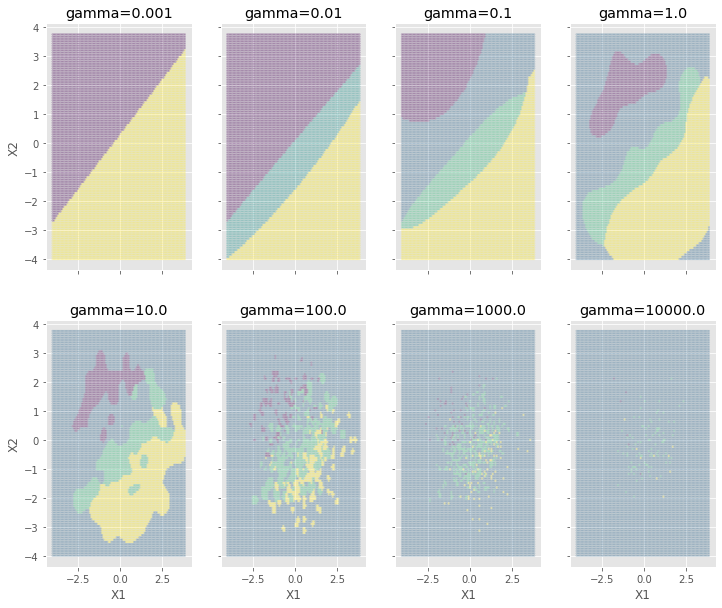

In [7]:
g_seq=list(np.logspace(-3,4,8))
pyplot.style.use('ggplot')
fig, axs = pyplot.subplots(2,4, figsize=(12,10))
svc_g_train, svc_g_test = plot_boundaries('gamma', g_seq, fig, axs)
pyplot.show()

In [8]:
for i, g in enumerate(g_seq):    
    print('SVC with gamma = '+str(g))
    print('Training AUC: ' + str(round(svc_g_train[i],5)))
    print('Testing AUC: '+str(round(svc_g_test[i],5))+'\n')

SVC with gamma = 0.001
Training AUC: 0.7386
Testing AUC: 0.74546

SVC with gamma = 0.01
Training AUC: 0.74704
Testing AUC: 0.7555

SVC with gamma = 0.1
Training AUC: 0.75008
Testing AUC: 0.76178

SVC with gamma = 1.0
Training AUC: 0.76211
Testing AUC: 0.75069

SVC with gamma = 10.0
Training AUC: 0.81448
Testing AUC: 0.72936

SVC with gamma = 100.0
Training AUC: 0.93314
Testing AUC: 0.66432

SVC with gamma = 1000.0
Training AUC: 0.99859
Testing AUC: 0.58776

SVC with gamma = 10000.0
Training AUC: 0.90825
Testing AUC: 0.53445



However, combining the values of C and G with best testing performance is often ideal. Better is to fit an SVC on the training data for each value of C and gamma in some prespecified ranges, and find the combination with the smallest average testing error rate over k-folds (here k = 5). The decision boundary and validation AUC of the model with the highest testing AUC is plotted.

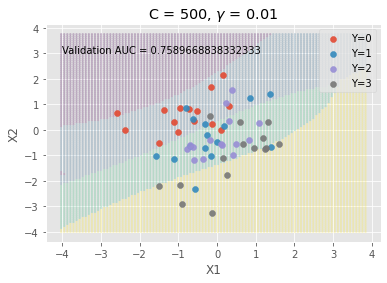

In [10]:
np.random.seed(21)
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def my_roc_auc_score(y_true, proba):
    return roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
scorer=make_scorer(my_roc_auc_score, greater_is_better=True, needs_proba=True)

c_seq=[.5,1,5
       ,10,20,50,100,500
      ]
g_seq=[.001,.01,.1,1
       ,10,100,1000,10000
      ]
paramters={'C':list(c_seq),'gamma':list(g_seq)}
svc_cv=GridSearchCV(SVC(probability=True)
                    ,param_grid=paramters
                    ,scoring=scorer
                    ,cv=5
                    ).fit(X_train, y_train)
grid_svc_predict=list(svc_cv.best_estimator_.predict(grid))

pyplot.style.use('ggplot')
fig, ax = pyplot.subplots()

pyplot.scatter(grid['X1'].tolist(),grid['X2'].tolist(),c=grid_svc_predict, alpha=.2,s=3)
for i, s in enumerate(scatter_points):
    ax.scatter(s['X1'].tolist(), s['X2'].tolist(), label='Y={}'.format(i), alpha=.9)
    
pyplot.legend()
pyplot.ylabel('X2')
pyplot.xlabel('X1')
pyplot.title(r'C = {}, $\gamma$ = {}'.format(svc_cv.best_params_['C'], svc_cv.best_params_['gamma']))
pyplot.text(-4,3,'Validation AUC = {}'
            .format(roc_auc_score(y_test, svc_cv.predict_proba(X_test), multi_class='ovr', average='weighted'))
           )
ax.legend()
pyplot.show()

Dishearteningly, this is a (slightly) worse performing model than QDA. Instead of GridSearchCV, we try randomly sampling tuning parameters. Let's take a look at the mean test cross-validation score for each fitted SVC.

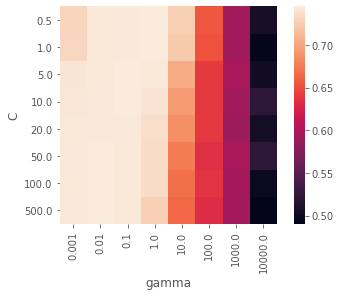

In [11]:
grid_results_df=pd.DataFrame({'C':list(svc_cv.cv_results_['param_C']),
                              'gamma':list(svc_cv.cv_results_['param_gamma']),
                              'mean_test_score':list(svc_cv.cv_results_['mean_test_score'])}
                            )
grid_results_df=grid_results_df.pivot('C', 'gamma', 'mean_test_score')

import seaborn as sns
sns.heatmap(grid_results_df, square=True)
pyplot.show()

We can do similar with a larger distribution of possible values, but we won't use k-fold cross-validation and rather just testing AUC.

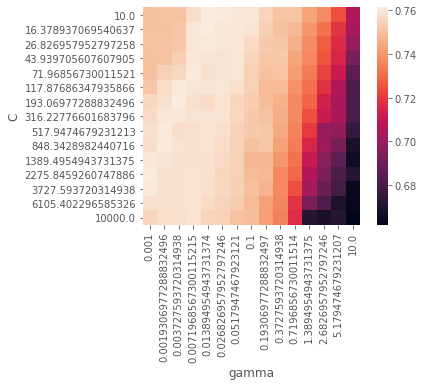

In [12]:
c_seq=list(np.logspace(1,4,15))
g_seq=list(np.logspace(-3,1,15))
test_auc=[]

c_list, g_list = [], []

for c, g in itertools.product(c_seq, g_seq):
    c_list.append(c)
    g_list.append(g)
    svc=SVC(C=c,gamma=g,probability=True).fit(X_train,y_train)
    test_auc.append(roc_auc_score(y_test, svc.predict_proba(X_test), multi_class='ovr', average='weighted'))
    
big_heat_df=pd.DataFrame({'C': c_list,
                          'gamma': g_list,
                          'test_auc': test_auc})
big_heat_df=big_heat_df.pivot('C','gamma','test_auc')
sns.heatmap(big_heat_df, square=True)
pyplot.show()

Based on the above heatmap, it looks like we will have trouble getting beyond a validation AUC of .76 with an RBF SVC. But we are stubborn, so we try randomly sampling different parametrizations and see what we get.

In [13]:
dists=dict(C=list(np.logspace(-1,3,500)),
           gamma=list(np.logspace(-3,2,500)))

from sklearn.model_selection import RandomizedSearchCV
svc_cv_rand=RandomizedSearchCV(SVC(probability=True)
                               ,param_distributions=dists
                               ,scoring=scorer
                               ,cv=5
                               ,n_iter=50
                               ,random_state=23
                              ).fit(X_train, y_train)

In [14]:
print(svc_cv_rand.best_params_)

{'gamma': 0.016308906755493326, 'C': 744.2922330043758}


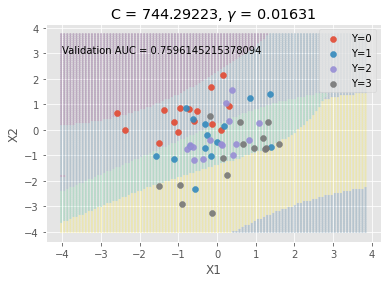

In [15]:
grid_svc_predict=list(svc_cv_rand.best_estimator_.predict(grid))

fig, ax = pyplot.subplots()

pyplot.scatter(grid['X1'].tolist(),grid['X2'].tolist(),c=grid_svc_predict, alpha=.2,s=3)
for i, s in enumerate(scatter_points):
    ax.scatter(s['X1'].tolist(), s['X2'].tolist(), label='Y={}'.format(i), alpha=.9)
    
pyplot.legend()
pyplot.ylabel('X2')
pyplot.xlabel('X1')
pyplot.title(r'C = {}, $\gamma$ = {}'.format(
                                            round(svc_cv_rand.best_params_['C'],5),
                                            round(svc_cv_rand.best_params_['gamma'],5))
                                            )
pyplot.text(-4,3,'Validation AUC = {}'
            .format(roc_auc_score(y_test, svc_cv_rand.predict_proba(X_test), multi_class='ovr', average='weighted'))
           )
ax.legend()
pyplot.show()